In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import display
print("TensorFlow version: ",tf.__version__)
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)

TensorFlow version:  1.15.0
numpy version:  1.19.2
pandas version:  1.0.1


# TensorFlow的基本概念

## 张量,计算图和会话

TF中主要有如下三个部分：  

+ 张量——数据模型  
张量也就是多维数组，用于表示数据. 张量有三个属性：
  1. name
  2. shape
  3. dtype
  

+ 计算图——计算模型  
计算图是整个计算过程的表示，每个`tf.Graph`包括两个部分：
  1. Graph structure.  
    + 图中每一个节点表示运算操作，是一个`tf.Operation`
    
    > Operations describe calculations that consume and produce tensors.
    
    + 每条边表示运算操作之间的依赖关系，是一个`tf.Tensor`
    
    > represent the values that will flow through the graph.
      
  2. Graph collections  
  用于存储图的一些元数据。


+ 会话——运行模型  
计算图中定义的每个运算操作必须在一个会话中执行。


TensorFlow计算图表示如下含义：  
+ 每一个节点表示一个计算，或者说操作(operation)
+ 节点之间的边描述了计算之间的依赖关系。

<img src="images/f1.png" width="30%" align="left">

上述的图定义的是如下的运算：  
$add = a + b$   
对应的TF实现如下

In [121]:
a = tf.constant(1)
b = tf.constant(2)
add = tf.add(a,b)
print(a)
print(add)

Tensor("Const:0", shape=(), dtype=int32)
Tensor("Add:0", shape=(), dtype=int32)


上述定义的`add`是表示加法的这个操作，实际上，`a`和`b`也是表示操作——对应的是**常量赋值**这个操作，这就是每个节点是一个计算的含义。 

`print`打印的是每个节点对应的操作下，对应输出的张量，可以看出，每个张量打印的时候，输出了张量的三种属性：name, shape, dtype.  

节点a和b经过相加后得到节点add，这就是一个依赖关系。

因为是定义的计算节点，所以打印出的结果并不是实际的值。**要想打印出计算节点对应的值，必须要开启一个会话，在会话中进行图的计算**.

In [61]:
# 使用tf.Session()创建一个会话
with tf.Session() as sess:
    # 使用 session.run()方法实际执行图中的计算节点，传入的参数是某个节点，返回的是该计算节点对应的值
    print(sess.run(a))
    print(sess.run(b))
    print(sess.run(add))

1
2
3


另一种执行计算图的方式是使用`tf.InteractiveSession()`开启一个默认的会话，这样就不用每次都指定对话了。  
实际上，`tf.InteractiveSession()`相当于
```python
sess=tf.Session()
with sess.as_default():
```

In [122]:
# TF中开启用于交互下的默认会话
sess = tf.InteractiveSession()

# 开启后，可以直接使用.eval()方法执行
print(a.eval())
print(b.eval())
print(add.eval())

# 关闭默认会话
tf.InteractiveSession.close(sess)

1
2
3


+ 以下是一个矩阵乘法的例子

In [5]:
# 定义两个常量赋值操作
a = tf.constant([ [3,3] ])
b = tf.constant([ [2], [3] ])

# 定义一个矩阵乘法操作
prod = tf.matmul(a, b)
print(prod)

Tensor("MatMul:0", shape=(1, 1), dtype=int32)


In [6]:
# 使用会话来运行上述定义的运算
with tf.Session() as sess:
    # 调用sess.run()方法来执行上述定义的运算
    result = sess.run(prod)
    print(result.__class__,"\n",result)

<class 'numpy.ndarray'> 
 [[15]]


## 变量的使用

变量`tf.Variable`有如下作用:  
1. 保存神经网络的参数
2. 获取神经网络中间的结果

变量和张量的区别和联系：  
1. 变量是特殊的张量，它们之间的关系，就相当于**张量是常规的值，是不可变的**，而变量可以存储不同的张量。  
2. 变量也有张量的三个属性：name, shape, dtype。
3. 变量的name和dtype都是不可改变的，shape虽然可以改变，但是很少见到这种用法。


有两种方式定义变量：  
1. `tf.Variable()`，这是一个类的初始化方法
2. `tf.get_variable（）`，这是类的静态方法，**推荐使用这个**。

注意： 
`tf.Variable()`创建变量时，如果指定的名称对应于已存在的变量，**会直接覆盖而不提示**; `tf.get_variable()`在遇到同名变量时，**则会报错提醒。**

+ `tf.get_variable(
    name, shape=None, dtype=None, initializer=None, regularizer=None,
    trainable=None, collections=None, caching_device=None, partitioner=None,
    validate_shape=True, use_resource=None, custom_getter=None, constraint=None,
    synchronization=tf.VariableSynchronization.AUTO,
    aggregation=tf.VariableAggregation.NONE
)`  
  **Gets an existing variable with these parameters or create a new one.**
  + `name`，指定变量名称,必须指定。
  + `shape`，指定维度
  + `dtype`，指定类型， 也可以省略，TF可以自动推断
  + `initializer`，初始化方式，可以是一个Tensor，也可以是
  + `regularizer`,可以传入一个正则化函数，同时将该变量加入到`tf.GraphKeys.REGULARIZATION_LOSSES`这个集合里。
  + `trainable`，布尔值，如果为True，则会将该变量加入到`tf.GraphKeys.TRAINABLE_VARIABLES`这个集合里。
  + `collections`，一个list，包含了想加入的collections名称. 默认为`GraphKeys.GLOBAL_VARIABLES`。

In [66]:
# 定义一个变量并初始化为0的操作，
# 注意，这里只是定义初始化的方法（是用常量初始化还是用随机数初始化），但是并没有执行初始化
state = tf.Variable(0, name="state")

# 定义一个运算，使var每次加1
new_value = tf.add(state, 1)
# 上面的方式等价于下面这种
# new_value = state + 1

# 定义赋值操作
update = tf.assign(state, new_value)

# 定义变量初始化操作
init = tf.global_variables_initializer()

# 创建会话运行上述定义的操作
with tf.Session() as sess:
    # 执行变量的初始化操作
    sess.run(init)
    print(sess.run(state))
    for _ in range(5):
        sess.run(update)
        print(sess.run(state))

0
1
2
3
4
5


这里有两个需要注意的地方：
1. `new_value = tf.add(state,1)` **等价于** ` new_value = state + 1`，详见讨论[In tensorflow what is the difference between tf.add and operator (+)?
](https://stackoverflow.com/questions/37900780/in-tensorflow-what-is-the-difference-between-tf-add-and-operator)
2. `update = tf.assign(state, new_value)` 和 `state = new_value` 的区别. **有待讨论**

In [79]:
new_value_1 = tf.add(state,1)
new_value_2 = state + 1
print(new_value_1)
print(new_value_2)
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(new_value_1))
    print(sess.run(new_value_2))
    
# print('---------------------------------------')

# del update_1
# update_1 = tf.assign(state, new_value)
# state = new_value
# print(update_1)
# print(state)
# with tf.Session() as sess:
#     sess.run(init)
#     print(sess.run(update_1))
#     print(sess.run(state))

Tensor("Add_24:0", shape=(), dtype=int32)
Tensor("add_25:0", shape=(), dtype=int32)
2
2
---------------------------------------


## placeholder机制，Fetch和Feed

TensorFlow 提供了 placeholder 机制用于提供输入数据。  
placeholder 相当于定义了一个位置，这个位置中的数据在程序运行时再指定。

**placeholder通常用于传入一个batch的训练数据**。

Fetch是指一个session中运行多个operation。 

Feed是指以字典的形式，向placeholder中传入数据。  

上述两个概念都是`Session.run()`方法的参数，可以查阅该函数的帮助文档

In [8]:
w1 = tf.Variable(tf.random_normal([2,3]))

# 定义一个placeholder需要提供类型（之后不可改变），shape不是必须的，但是提供了shape可以避免歧义和错误
x = tf.placeholder(tf.float32, shape=(3,1), name='x')

# 使用placeholder代替常量进行矩阵乘法操作的定义
y = tf.matmul(w1, x)

# 变量初始化操作
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(w1))
    # 执行y定义的操作的时候，需要传入placeholder x对应的值
    print(sess.run(y, feed_dict={x:[[1],[2],[3]]}))

[[ 0.6277467 -2.845186  -0.6237103]
 [-1.3152791 -0.8063137  1.9430356]]
[[-6.9337564]
 [ 2.9012003]]


## 损失函数

[`tf.losses`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/losses)模块封装了各种损失函数的计算operation。  

默认情况下，`tf.GraphKeys.LOSSES`中的变量都会当做损失函数的参数，放入到损失函数中进行计算。

In [112]:
#----------这是一个线性模型的示例---------
# 首先清空默认图的节点
tf.reset_default_graph()
# 以下的线性模型是 y = w*x ,没有截距项b
# x的四个样本点，4 x 1的矩阵
x = tf.constant(value=[[1,2,3,4]], dtype=tf.float32, name='x')
# w 是 1维 的参数， 1x1 的矩阵
w = tf.get_variable(name='w', initializer=tf.random_normal(shape=[1,1]), trainable=True)
# y的实际值，对应于x的四个样本点，有四个值，4 x 1 的矩阵
y = tf.constant(value=[[1,4,9,16]], dtype=tf.float32, name='y')
# 预测值 y_pred = x*w
y_pred = tf.matmul(w, x, name='y_pred')

# 
display(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
# display(tf.get_collection(tf.GraphKeys.LOSSES))
# 平方损失函数的计算operation
mse_loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)

init = tf.global_variables_initializer()

display(x)
display(w)
display(y)
display(y_pred)
display(mse_loss)

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(x))
    print(sess.run(w))
    print(sess.run(y))
    print(sess.run(y_pred))
    print(sess.run(mse_loss))

[<tf.Variable 'w:0' shape=(1, 1) dtype=float32_ref>]

<tf.Tensor 'x:0' shape=(1, 4) dtype=float32>

<tf.Variable 'w:0' shape=(1, 1) dtype=float32_ref>

<tf.Tensor 'y:0' shape=(1, 4) dtype=float32>

<tf.Tensor 'y_pred:0' shape=(1, 4) dtype=float32>

<tf.Tensor 'mean_squared_error/value:0' shape=() dtype=float32>

[[1. 2. 3. 4.]]
[[-1.6390375]]
[[ 1.  4.  9. 16.]]
[[-1.6390375 -3.278075  -4.9171124 -6.55615  ]]
190.6002


## 优化器  

上面定义了损失函数之后，就需要对损失函数进行求梯度，进行梯度下降的优化。  
[`tf.train`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train)模块封装了梯度下降的优化步骤。  

其中的`tf.train.Optimizer`是所有优化器的基类，最常用的简单梯度下降优化器是`tf.train.GradientDescentOptimizer`。

以`tf.train.GradientDescentOptimizer`类为例，以下说明优化器的使用。
1. 首先优化器的必要的类构造参数是学习率，也就是梯度下降每一步的步长，以此来初始化类的实例
```python
tf.train.GradientDescentOptimizer(
    learning_rate, use_locking=False, name='GradientDescent'
)
```
2. 使用学习率初始化类，得到一个实例对象之后，在此对象上调用`.minimize()`方法，传入的参数是需要优化的损失函数。
```python
tf.train.GradientDescentOptimizer.minimize(
    loss, global_step=None, var_list=None, gate_gradients=GATE_OP,
    aggregation_method=None, colocate_gradients_with_ops=False, name=None,
    grad_loss=None
)
```

调用上面的`minimize()`方法时，其实产生了两个步骤：
1. 计算有关参数的梯度，实际上是调用了`.compute_gradients()`方法
2. 将梯度更新应用到有关参数上，实际上是调用了`.apply_gradients()`方法

`.minimize()`方法的返回值是一个更新`var_list`的`tf.Operation`.

In [120]:
tf.reset_default_graph()
# 以下的线性模型是 y = w*x ,没有截距项b
# x的四个样本点，4 x 1的矩阵
x = tf.constant(value=[[1,2,3,4]], dtype=tf.float32, name='x')
# w 是 1维 的参数， 1x1 的矩阵
w = tf.get_variable(name='w', initializer=tf.random_normal(shape=[1,1]), trainable=True)
# y的实际值，对应于x的四个样本点，有四个值，4 x 1 的矩阵
y = tf.constant(value=[[1,4,9,16]], dtype=tf.float32, name='y')
# 预测值 y_pred = x*w
y_pred = tf.matmul(w, x, name='y_pred')

# 平方损失函数的计算operation
mse_loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)

# 定义优化器
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(mse_loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print("运行梯度优化之前的权重和MSE：")
    print(sess.run(w))
    print(sess.run(mse_loss))
    
    print(sess.run(train_step))
    
    print("运行梯度优化之后的权重和MSE：")
    print(sess.run(w))
    print(sess.run(mse_loss))

运行梯度优化之前的权重和MSE：
[[-0.6395329]]
123.54417
None
运行梯度优化之后的权重和MSE：
[[2.3401167]]
12.565261


## 学习率

这里主要介绍指数衰减学习率函数
+ `tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)`
  + `learning_rate`，初始学习率
  + `global_step`，全局的迭代步数
  + `decay_steps`，**衰减步数** .  
  这个值通常**取完整使用一次训练数据所需要的的步数**，也就是总样本数/batch_size。
  + `decay_rate`，指数衰减率
  + `staircase`,布尔值，为True时，会将$\frac{global\_step}{decay\_steps}$的值转成一个整数，这样学习率的衰减曲线就是阶梯状的了.
  
上述函数会产生如下衰减的学习率：  
$decayed\_learning\_rate = learning\_rate \times decay\_rate^{\frac{global\_step}{decay\_steps}}$.  
其中$decay\_rate < 1$，随着迭代次数 $global\_step$ 不断增加，$frac{global\_step}{decay\_steps}$也越来越大，所以整个指数越来越小.

## 正则化

可以参见讨论 [How to add regularizations in TensorFlow?](https://stackoverflow.com/questions/37107223/how-to-add-regularizations-in-tensorflow)

+ TensorFlow对参数进行正则化的方法有两个：
  1. 使用`tf.nn.l2_loss(w)`函数  
  这个会直接计算`w`的二范数，返回结果的Tensor
  2. 使用` tf.contrib.layers.l2_regularizer(alpha)`方法，但是这个方法在tf1.15中被标记为“弃用”，所以不推荐。  
  传入的参数`alpha`是正则化项前面的超参数，之后会返回一个函数，此函数接受的参数才是权重，最后计算得到的是参数的二范数乘上系数`alpha`的Tensor。

In [35]:
tf.reset_default_graph()

# 使用 tf.nn.l2_loss()
w = tf.constant([1.0,2.0,3.0])
reg_l2 = tf.nn.l2_loss # 注意，这里不要加括号，加了就是调用方法了
with tf.Session() as sess:
    print(sess.run(w))
    print(sess.run(reg_l2(w)))
    
    
reg_l2 = tf.contrib.layers.l2_regularizer(scale=0.5) #返回的是一个函数
w = tf.constant([1.0,2.0,3.0])
with tf.Session() as sess:
    print(sess.run(w))
    print(sess.run(reg_l2(w)))

[1. 2. 3.]
7.0
[1. 2. 3.]
3.5


上述得到的结果就是对向量$(1,2,3)$使用L2正则得到的结果：$\frac{1}{2}\times 1.0 \times(1^2+2^2+3^2)=\frac{1}{2}\times 1.0 \times(1+4+9)=7$

+ 对参数执行正则化的方式有两种
1. 使用`tf.get_variable()`创建变量时，通过参数`regularizer=`指定正则化函数.  
这种情况下，会自动将正则化后的参数加入到`tf.GraphKeys.REGULARIZATION_LOSSES`集合中.
2. 手动计算正则化参数的项，并加入到`tf.GraphKeys.REGULARIZATION_LOSSES`集合中.  
使用`tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weights)`

+ 计算完参数的正则化项之和，接下来需要计算正则项的Loss，并将其加入到原本的Loss函数中  
这里有两种：
1. 手动取出所有的正则化参数，并计算Loss
2. 使用` tf.losses.get_regularization_loss()`自动计算

In [39]:
tf.reset_default_graph()
print("tf.GraphKeys.GLOBAL_VARIABLES")
display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
# print("tf.GraphKeys.WEIGHTS")
# display(tf.get_collection(tf.GraphKeys.WEIGHTS))
print("tf.GraphKeys.TRAINABLE_VARIABLES")
display(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
print("tf.GraphKeys.REGULARIZATION_LOSSES")
display(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
print('----------------------------------------------------\n')

w = tf.constant([1.0,2.0,3.0])
# -- 方式 1 -----------
# 创建参数同时，自动将它加入正则化集合里
# weight = tf.get_variable(name='w', initializer=w, regularizer=tf.nn.l2_loss)
# --- 方式 2 ----------
# 创建参数，手动加入正则化集合
weight = tf.get_variable(name='w', initializer=w)
reg_w = tf.nn.l2_loss(weight)
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, reg_w)

# 接下来提取 正则化参数的 Loss，手动计算loss
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_loss = 1 * tf.add_n(reg_variables)
# 或者直接得到正则化参数的loss
reg_loss_auto = tf.losses.get_regularization_loss()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    display(sess.run(weight))
    display(sess.run(reg_loss))
    display(sess.run(reg_loss_auto))

print('\n----------------------------------------------------')
print("tf.GraphKeys.GLOBAL_VARIABLES")
display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
# print("tf.GraphKeys.WEIGHTS")
# display(tf.get_collection(tf.GraphKeys.WEIGHTS))
print("tf.GraphKeys.TRAINABLE_VARIABLES")
display(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
print("tf.GraphKeys.REGULARIZATION_LOSSES")
display(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

tf.GraphKeys.GLOBAL_VARIABLES


[]

tf.GraphKeys.TRAINABLE_VARIABLES


[]

tf.GraphKeys.REGULARIZATION_LOSSES


[]

----------------------------------------------------



array([1., 2., 3.], dtype=float32)

7.0

7.0


----------------------------------------------------
tf.GraphKeys.GLOBAL_VARIABLES


[<tf.Variable 'w:0' shape=(3,) dtype=float32_ref>]

tf.GraphKeys.TRAINABLE_VARIABLES


[<tf.Variable 'w:0' shape=(3,) dtype=float32_ref>]

tf.GraphKeys.REGULARIZATION_LOSSES


[<tf.Tensor 'L2Loss:0' shape=() dtype=float32>]

## `tf.math`下的常用运算函数

In [112]:
value = [[1.0, 2.0, 3.0],
     [4.0, 5.0, 6.0]]
x = tf.constant(value)

y1 = tf.constant(value)
y2 = tf.constant(value)
y3 = y1+y2

with tf.Session() as sess:
    print(x.eval())
    
    # reduce 类函数
    print("\nreduce_xx方法")
    print( tf.reduce_sum(x).eval() )
    print( tf.reduce_sum(x, axis=0).eval() )
    print( tf.reduce_sum(x, axis=1).eval() )
    
    # add_n函数
    print("\nadd_n方法")
    print( tf.add_n([y1,y2]).eval() )
    print( y3.eval())
    
    # argmax函数
    print("\nargmax方法")
    print(tf.argmax(input=x).eval())
    print(tf.argmax(input=x, axis=0).eval())
    print(tf.argmax(input=x, axis=1).eval())

[[1. 2. 3.]
 [4. 5. 6.]]

reduce_xx方法
21.0
[5. 7. 9.]
[ 6. 15.]

add_n方法
[[ 2.  4.  6.]
 [ 8. 10. 12.]]
[[ 2.  4.  6.]
 [ 8. 10. 12.]]

argmax方法
[1 1 1]
[1 1 1]
[2 2]


## 简单使用案例

In [11]:
# 构造100个数据点
x_data = np.random.rand(100)
y_data = x_data * 0.1 + 0.2

#构造一个带训练的线性模型
a = tf.Variable(0.)
b = tf.Variable(0.)
y = a * x_data + b

# 二次代价函数
loss = tf.reduce_mean(tf.square(y - y_data))

# 定义优化器
optimizer = tf.train.GradientDescentOptimizer(0.2)

#最小化代价函数
train = optimizer.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()

# 构建session
with tf.Session() as sess:
    sess.run(init)
    for step in range(201):
        sess.run(train)
        if step%20 == 0:
            print(step, sess.run([a, b]))

0 [0.054953318, 0.10058578]
20 [0.10441639, 0.19757646]
40 [0.102669686, 0.19853504]
60 [0.10161378, 0.19911446]
80 [0.1009755, 0.19946471]
100 [0.10058967, 0.19967642]
120 [0.10035645, 0.1998044]
140 [0.10021548, 0.19988175]
160 [0.100130245, 0.19992852]
180 [0.100078724, 0.1999568]
200 [0.10004757, 0.1999739]


In [12]:
# 获取默认的计算图
tf.get_default_graph()

## 完整的神经网络程序示例

有三个步骤：  
1. 定义神经网络的结构和前向传播的输出结果。
2. 定义损失函数以及选择反向传播优化的算法 。
3. 生成会话（ tf.Session ）并且在训练、数据上反复运行反向传播优化算法

作为示例的神经网络如下图所示：  
**它只有一个隐藏层，并且隐藏层没有使用激活函数。**

<img src="images/f2.png" width="70%" align="left">

In [13]:
# 使用numpy随机模拟数据
from numpy.random import RandomState

rnd = RandomState(29)
datasize = 128
# 随机生成 datesize x 2 的矩阵
X = rnd.rand(datasize,2)
# 对于X中的每一行，计算一个对于的 Y 值，
Y = [ [int(x1+x2<1)] for (x1,x2) in X]

print(X[:5,:])
print(Y[:5])

[[0.86375999 0.28490597]
 [0.07325639 0.7632372 ]
 [0.45271906 0.54229687]
 [0.72663578 0.84890511]
 [0.76819998 0.73314372]]
[[0], [1], [1], [0], [0]]


In [14]:
#---------步骤1--------------
# 定义训练数据batch大小
batch_size = 8

# 定义神经网络的参数
# w1是输入层到隐藏层的权重矩阵, 2 x 3
w1 = tf.Variable(tf.random_normal([2,3]))
# w2是隐藏层到输出层的权重大小，3 x 1
w2 = tf.Variable(tf.random_normal([3,1]))

#定义placeholder，用于接受数据
# shape里第一个维度留None，可以用于动态适应输入的batch大小
x_batch = tf.placeholder(tf.float32, shape=(None, 2), name="x_batch")
y_batch = tf.placeholder(tf.float32, shape=(None, 1), name="y_batch")


#---------步骤2--------------
#定义神经网络的前向传播过程，这里采用矩阵运算
a = tf.matmul(x_batch, w1)
y = tf.matmul(a, w2)  # 这个 y 是神经网络输出的 y

# 定义损失函数和反向传播的优化算法
y = tf.sigmoid(y)
# 使用交叉熵作为损失函数
cross_entropy = - tf.reduce_mean(
    y_batch * tf.log(tf.clip_by_value(y, 1e-10, 10)) +
    (1-y_batch) * tf.log(tf.clip_by_value(y,1e-10, 10))
)

# 优化算法
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

#---------步骤3--------------
# 开启会话，进行训练
with tf.Session() as sess:
    # 初始化变量
    init = tf.global_variables_initializer()
    sess.run(init)
    # 打印训练之前权重矩阵的值
    print("w1:")
    print(sess.run(w1))
    print("w2:")
    print(sess.run(w2))
    
    # 设定训练轮数
    STEPS = 5000
    for i in range(STEPS):
        # 每次选择batch_size个样本进行运算，这里生成的是样本的index范围
        batch_start = (i * batch_size) % datasize
        batch_end = min(batch_start+batch_size, datasize)
        
        # 对每个batch进行训练并更新参数
        sess.run(train_step, feed_dict={x_batch:X[batch_start:batch_end,:], y_batch:Y[batch_start:batch_end]})
        
        # 每隔一段时间就打印一次训练过程中全部数据集上的交叉熵
        if i%500 == 0:
            total_cross_entropy = sess.run(cross_entropy , feed_dict={x_batch:X, y_batch:Y})
            print("经过 {} 次训练，所有数据上的交叉熵损失为：{:g}".format(i, total_cross_entropy))
            
    # 打印训练之后权重矩阵的值
    print("w1")
    print(sess.run(w1))
    print("w2")
    print(sess.run(w2))
        

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
w1:
[[ 0.28952682  1.9308614   0.5419188 ]
 [-0.11188115 -2.566612   -0.41635063]]
w2:
[[-0.64926267]
 [-0.8263266 ]
 [ 0.8473202 ]]
经过 0 次训练，所有数据上的交叉熵损失为：0.617352
经过 500 次训练，所有数据上的交叉熵损失为：0.224531
经过 1000 次训练，所有数据上的交叉熵损失为：0.0864119
经过 1500 次训练，所有数据上的交叉熵损失为：0.04642
经过 2000 次训练，所有数据上的交叉熵损失为：0.0299731
经过 2500 次训练，所有数据上的交叉熵损失为：0.0212891
经过 3000 次训练，所有数据上的交叉熵损失为：0.0159384
经过 3500 次训练，所有数据上的交叉熵损失为：0.0123008
经过 4000 次训练，所有数据上的交叉熵损失为：0.00967179
经过 4500 次训练，所有数据上的交叉熵损失为：0.00769481
w1
[[-1.5155436  0.6918462  2.008162 ]
 [-1.7760524 -3.6705172  0.9140369]]
w2
[[-3.071673 ]
 [-1.686208 ]
 [ 2.6975398]]


## 模型持久化

TensorFlow提供了`tf.train.Saver`类来对计算图进行保存和恢复.

保存后，会在指定文件夹下产生三个文件：
1. `xxx.ckpt.meta`文件，保存的计算图结构
2. `xxx.ckpt`或者`xxx.ckpt.index`文件，保存计算图中所有变量的取值
3. `xxx.checkpoint`文件，记录的当前文件夹下所保存的所有模型文件列表

+ 保存模型的函数
`tf.train.Saver.save(
    sess, save_path, global_step=None, latest_filename=None,
    meta_graph_suffix='meta', write_meta_graph=True, write_state=True,
    strip_default_attrs=False, save_debug_info=False
)`
  + `sess`，运行计算图的会话
  + `save_path`，保存模型的路径，需要包含保存的模型名称
  + `global_step`，如果提供了步长参数，则会在保存的模型后面加上步长作为后缀
  
+ 恢复模型的函数
`restore(sess, save_path)`
  + `sess`，当前使用的会话
  + `save_path`，模型保存的路径

In [187]:
%pwd

'D:\\Project-Workspace\\Python-Projects\\DataAnalysis\\Practice'

In [190]:
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name='v2')
result = v1 + v2
init = tf.global_variables_initializer()

# 实例化保存模型的类，相当于创建了一个保存计算图的 tf.Opeartion
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(result))
    saver.save(sess, "./TensorFlow-Saved-Models/model-save-test.ckpt")

[3.]


In [55]:
# 加载已保存的模型
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state("./TensorFlow-Saved-Models/")

# with tf.Session() as sess:
#     saver.restore(sess, "./TensorFlow-Models/model-save-test.ckpt.index")
#     print(sess.run(tf.get_default_graph().get_tensor_by_name("v1:0")))

In [62]:
ckpt.model_checkpoint_path

'./TensorFlow-Saved-Models/mnist_dnn_model.cpkt-40000'

## TFRecords

有关TFRecords的介绍可以参考如下的博客：
1. [Tensorflow Records? What they are and how to use them](https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564)-KEY   
这个介绍的最详细
2. [高效读取数据的方法（TFRecord）](https://www.cnblogs.com/wj-1314/p/11211333.html)

TFRecords是TF中用于存储序列化后二进制数据的格式，它能够高效的提供IO操作。  
构建TFRecords，必须要指定这些序列化数据的格式，这个可以通过 `tf.train.Example` 和 `tf.train.SequenceExample` 两种来实现，这里主要介绍第一个。

+ `tf.train.Example`不是一个普通的python类，它是一个 protocal buffer，构建一个`Example`，并将其转成 TFRecord 需要如下5个步骤：
  1. 对于每个特征，需要指定这个特征的类型，并且将这个特征的所有值都组织成一个列表，可以选择的取值有如下三种：
    + `tf.train.BytesList`
    + `tf.train.FloatList`
    + `tf.train.Int64List`
  2. 对上一步中每个特征的取值进行封装，使用 `tf.train.Feature`类 封装成一个 `Feature` 对象
  3. 将所有的特征封装成一个特征的集合对象 `tf.train.Features`，
  4. 将特征集合封装成一个 `tf.train.Example` 对象
  5. 将上述的 `Example` 对象通过 `tf.python_io.TFRecordWriter` 进行序列化，写入一个 TFRecord 对象保存。
  
+ 从 TFRecord 文件中读取数据的流程如下：
  1. 使用`tf.TFRecordReader` 读取文件
  2. 根据指定的特征结构抽取信息
  3. 解析出特征

In [4]:
# 假设要导入的数据如下：
df = pd.DataFrame({'feature_1':[1,2,3], 'feature_2':['a','b','c']})
df

,feature_1,feature_2
0,1,a
1,2,b
2,3,c


In [32]:
# 分别定义每个特征的类型，并将每个特征的取值转成一个list
feature_1_list = tf.train.FloatList(value=df['feature_1'])
# 注意，str类型必须要先使用 str.encode() 方法获得对应的二进制编码
feature_2_list = tf.train.BytesList(value=df['feature_2'].apply(str.encode)) 

# 构造一个字典对象
features_dict = {}
features_dict['feature_1'] = tf.train.Feature(float_list=feature_1_list)
features_dict['feature_2'] = tf.train.Feature(bytes_list=feature_2_list)

# 使用上述得到的字典形式的特征集合，构造 Features 对象
features = tf.train.Features(feature=features_dict)

# 使用 Features 对象构造 Example
feature_example = tf.train.Example(features=features)
feature_example

features {
  feature {
    key: "feature_1"
    value {
      float_list {
        value: 1.0
        value: 2.0
        value: 3.0
      }
    }
  }
  feature {
    key: "feature_2"
    value {
      bytes_list {
        value: "a"
        value: "b"
        value: "c"
      }
    }
  }
}

In [35]:
# 然后调用 Example 对象的序列化方法，写入 TFRecord
with tf.python_io.TFRecordWriter('test_data.tfrecord') as writer:
    writer.write(feature_example.SerializeToString())

In [39]:
# 读取 TFRecord 文件
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(['test_data.tfrecord'])
_, serialized_example = reader.read(filename_queue)

read_features = {
    'feature_1': tf.FixedLenFeature([], tf.float64),
    'feature_2': tf.FixedLenFeature([], tf.string)
}

read_data = tf.parse_single_example(serialized=serialized_example, features=read_features)

TypeError: Value passed to parameter 'dense_defaults' has DataType float64 not in list of allowed values: float32, int64, string

## Dataset

[`tf.data`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/data)模块提供了用于封装数据输入的功能。  
最基本的类是`tf.data.Dataset`类，它又有三个子类：
1. `tf.data.TextLineDataset`
2. `tf.data.TFRecordDataset`
3. `FixedLengthRecordDataset`


利用数据集来读取数据通常有3个步骤：
1. 定义数据集的构造方法  
```python
inputs = [1,2,3,4,5]
dataset = tf.data.Dataset.from_tensor_slices(inputs)
```
2. 定义迭代器
```python
iterator = dataset.make_one_shot_iterator()
```
3. 使用`get_next()`方法从迭代器中读取batch，输入到计算图中.
```python
x=iterator.get_next()
```







---

# Estimator

+ 详细见如下博客
  1. [Introduction to Tensorflow Estimators](https://medium.com/learning-machine-learning/introduction-to-tensorflow-estimators-part-1-39f9eb666bc7)
  2. [TensorFlow之estimator详解](TensorFlow之estimator详解)

-----

# TensorFlow提供的网络结构 

TensorFlow有4个module提供网络结构：
1. `tf.nn`——这是最低层的网络结构API
2. `tf.layers`——它是对`tf.nn`的封装，高一级的API
3. `tf.keras`——keras封装，
4. `tf.contrib`——这个在1.15版本中已经被废弃了

## 全连接层

## Softmax层

In [63]:
# TF自带的softmax层
w = tf.constant([1.,2.,3.,4.])
res = tf.nn.softmax(w)

# 手动编写的sotfmax计算过程
w_ = np.array([1,2,3,4])
res_ = np.exp(w_)/np.exp(w_).sum()

with tf.Session() as sess:
    res_value = sess.run(res)
    print(res_value)
    print(res_)
    print(res_value.sum())
    print(res_.sum())

[0.0320586  0.08714432 0.23688284 0.6439143 ]
[0.0320586  0.08714432 0.23688282 0.64391426]
1.0
1.0


## 交叉熵

`tf.nn.softmax_cross_entropy_with_logits_V2(labels=, logits=)`可以对实际值和预测值做如下操作：
1. 先对预测值`logits`做softmax，转换成概率分布
2. 然后对两者的每个样本计算交叉熵损失

最终返回的是每个样本的带softmax的交叉熵损失，shape是`(batch_size,)`

如果样本的真实分类`labels`是one-hot编码，也就是每个样本的labels里只有一个是1，其他是0，此时可以使用`tf.nn.sparse_softmax_cross_entropy_with_logits`这个函数。

In [22]:
# 3个样本，每个样本可以取的分类是 3 种—— batch_size=3, class_num=3
y_output = [[1.0, 2.0, 3.0],
            [2.0, 3.0, 1.0],
            [2.0, 1.0, 3.0]]
# 三个样本的实际类别
y_true = [[1.0, 0.0, 0.0],
          [0.0, 1.0, 0.0],
          [0.0, 0.0, 1.0]]

# 代表实际输出的tensor
y_output_tensor = tf.constant(y_output)
# 代表真实样本类型的tensor
y_true_tensor = tf.constant(y_true)

# 首先对神经网络的原始输出做softmax，转换成概率，得到的也是 batch_size x class_num 的tensor
y_soft=tf.nn.softmax(y_output_tensor)
# 手动计算每个样本的交叉熵，
y_entropy = y_true_tensor*tf.log(y_soft)
# 这里本来应当是先求每个样本的交叉熵——每行求一次和，然后计算所有样本的交叉熵之和——列求和，没有指定维度，所以一口气全做了
cross_entropy_manual = -tf.reduce_sum( y_entropy )
cross_entropy_manual_vector = -tf.reduce_sum( y_entropy, axis=1 )

# 使用softmax_cross_entropy_with_logits_V2
# labels是真实值，logits是未经softmax之前的输出值
# 注意，它返回的是 batch_size长度的vector，也就是每个样本的单独交叉熵
cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true_tensor, logits=y_output_tensor)
# 计算所有样本的交叉熵之和
cross_entropy_auto = tf.reduce_sum(cross_entropy_vector)

# 下面可以看出，两种方式是一样的
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     display(y_soft.eval())
#     display(y_entropy.eval())
    display(cross_entropy_manual_vector.eval())
    display(cross_entropy_manual.eval())
    display(cross_entropy_vector.eval())
    display(cross_entropy_auto.eval())

array([2.407606  , 0.407606  , 0.40760598], dtype=float32)

3.2228177

array([2.407606  , 0.40760595, 0.40760595], dtype=float32)

3.2228177

In [42]:
y_true_tensor.shape

TensorShape([Dimension(3), Dimension(3)])

## CNN相关

+ 卷积层函数  
`tf.nn.conv2d(
    input, filter=None, strides=None, padding=None, use_cudnn_on_gpu=True,
    data_format='NHWC', dilations=[1, 1, 1, 1], name=None, filters=None
)`
  + `input`，输入层tensor，通常为4维, `[batch, in_height, in_width, in_channels]`
  + `filter`，指定卷积核的尺寸，必须是一个 **4维 tensor，每个维度对应于 `[filter_height, filter_width, in_channels, out_channels]`**
  + `strides`，指定在input上各个维度滑动的步长. 是一个 int 或者 长度为 1,2,4 的 int list.  
    + 如果是 `a`, 表示在图像的 height 和 width 维度上使用步长为 a 的滑动；
    + 如果是 `[a, b]`，表示在图像的 heigth 上滑动步长为 a, width 上为 b;
    + 如果是 `[a, b, c, d]`，表示input的四个维度分别指定，不过一般 height 和 width 上都设置为 1.
  + `padding`，表示是否边界0填充. 取值`SAME`和`VALID`，
  + `data_format`，字符串，从"NHWC", "NCHW"中选择。指定了各个维度的顺序。
  + `filters`，`filter`的别名
  
  它做了如下的步骤：
  1. 将shape=`[filter_height, filter_width, in_channels, out_channels]`的filter压缩成一个 2维矩阵，shape=`[filter_height * filter_width * in_channels, output_channels]`
  2. 将输入的input tensor转换成shape=`[batch, out_height, out_width, filter_height * filter_width * in_channels]`的tensor。
  3. 对于每一个batch，执行矩阵乘法。
  
  

+ 偏置项函数  
`tf.nn.bias_add(value, bias, data_format=None, name=None)`用于向卷积结果里添加偏置项
  + `value`，输入的tensor,通常是`tf.nn.conv2d`的结果
  + `bias`，一维的tensor，长度对应于 `value`的channel维。
  + `data_format`，维度顺序的含义
  
  
+ 池化层函数  
`tf.nn.max_pool2d(input, ksize, strides, padding, data_format='NHWC', name=None)`
  + `input`，一个 4维 tensor，`[batch, in_height, in_width, in_channels]`
  + `ksize`，An int or list of ints that has length 1, 2 or 4，指定池化层窗口大小。
  + `strides`，池化层步长。
  + `padding`

In [107]:
# 输入的是 2张 4x4x3 的图片，这里为了容易辨别，将通道数3提前了一点
imgs = np.arange(2*4*4*3,dtype=np.float32).reshape((2,3,4,4))
imgs_tensor = tf.constant(imgs)
# display(imgs)

# 卷积核为 2x2x3x2，步长为1，不做padding，过滤器数量为2
# 2个过滤器，分别为 [[1,0], [1,0]], [[0,1],[0,1]]三个通道都是一样的
f_w = np.array([1,1,0,0]*3 + [0,0,1,1]*3, dtype=np.float32).reshape((2,2,3,2), order='F')
# display(f_w[:,:,0,0])
filter_weight = tf.constant(f_w)

# 卷积层
# 因为imgs中将channel提前了，所以这里也要相应的设置data_format参数
conv = tf.nn.conv2d(input=imgs_tensor, filter=filter_weight, strides=1, padding='VALID', data_format='NCHW')

# 偏置
# 因为卷积核中有2个filter，所以新的channel=2，这里的偏置长度也是2
bias = tf.constant([0.0, 1.0])
conv_bias = tf.nn.bias_add(value=conv, bias=bias, data_format='NCHW')

# 最大池化层
# 池化层窗口为2x2,
conv_max_pool = tf.nn.max_pool2d(input=conv_bias, ksize=2, strides=1, padding='VALID', data_format='NCHW')

init = tf.global_variables_initializer()

print("原始的图像数据：2张图片，图片channel=3, 大小 4x4:")
print(imgs.shape)
display(imgs)

print("\n经过卷积后的数据：2张图片，新的channel=2, 卷积之后的图片大小 3x3")
with tf.Session() as sess:
    sess.run(init)
    print(conv.shape)
    print(sess.run(conv))
    print("\n添加bias后：2张图片，第1个channel +0, 第2个channel +1, 图片大小不变，仍为 3x3")
    print(conv_bias.shape)
    print(sess.run(conv_bias))
    print("\n经过最大池化层之后：2张图片, channel=2, 大小变为 2x2")
    print(conv_max_pool.shape)
    print(sess.run(conv_max_pool))

原始的图像数据：2张图片，图片channel=3, 大小 4x4:
(2, 3, 4, 4)


array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.]],

        [[32., 33., 34., 35.],
         [36., 37., 38., 39.],
         [40., 41., 42., 43.],
         [44., 45., 46., 47.]]],


       [[[48., 49., 50., 51.],
         [52., 53., 54., 55.],
         [56., 57., 58., 59.],
         [60., 61., 62., 63.]],

        [[64., 65., 66., 67.],
         [68., 69., 70., 71.],
         [72., 73., 74., 75.],
         [76., 77., 78., 79.]],

        [[80., 81., 82., 83.],
         [84., 85., 86., 87.],
         [88., 89., 90., 91.],
         [92., 93., 94., 95.]]]], dtype=float32)


经过卷积后的数据：2张图片，新的channel=2, 卷积之后的图片大小 3x3
(2, 2, 3, 3)
[[[[108. 114. 120.]
   [132. 138. 144.]
   [156. 162. 168.]]

  [[114. 120. 126.]
   [138. 144. 150.]
   [162. 168. 174.]]]


 [[[396. 402. 408.]
   [420. 426. 432.]
   [444. 450. 456.]]

  [[402. 408. 414.]
   [426. 432. 438.]
   [450. 456. 462.]]]]

添加bias后：2张图片，第1个channel +0, 第2个channel +1, 图片大小不变，仍为 3x3
(2, 2, 3, 3)
[[[[108. 114. 120.]
   [132. 138. 144.]
   [156. 162. 168.]]

  [[115. 121. 127.]
   [139. 145. 151.]
   [163. 169. 175.]]]


 [[[396. 402. 408.]
   [420. 426. 432.]
   [444. 450. 456.]]

  [[403. 409. 415.]
   [427. 433. 439.]
   [451. 457. 463.]]]]

经过最大池化层之后：2张图片, channel=2, 大小变为 2x2
(2, 2, 2, 2)
[[[[138. 144.]
   [162. 168.]]

  [[145. 151.]
   [169. 175.]]]


 [[[426. 432.]
   [450. 456.]]

  [[433. 439.]
   [457. 463.]]]]


## RNN相关

TensorFlow中RNN相关的module在`tf.nn.rnn_cell`这个模块中。  
+ 最基础的类是`RNNCell`，不过这是一个抽象类，一般使用它的如下几个子类：
  + `BasicRNNCell`
  + `GRUCell`
  + `LSTMCell`（还有一个`BasicLSTMCell`，不过1.15中已经被废弃了）
  + `MultiRNNCell`多层简单RNN


+ `tf.nn.rnn_cell.BasicRNNCell(
    num_units, activation=None, reuse=None, name=None, dtype=None, **kwargs
)`


+ `tf.nn.rnn_cell.GRUCell(
    num_units, activation=None, reuse=None, kernel_initializer=None,
    bias_initializer=None, name=None, dtype=None, **kwargs
)`


+ `tf.nn.rnn_cell.BasicLSTMCell(
    num_units, forget_bias=1.0, state_is_tuple=True, activation=None, reuse=None,
    name=None, dtype=None, **kwargs
)`

+ `tf.nn.rnn_cell.LSTMCell(
    num_units, use_peepholes=False, cell_clip=None, initializer=None, num_proj=None,
    proj_clip=None, num_unit_shards=None, num_proj_shards=None, forget_bias=1.0,
    state_is_tuple=True, activation=None, reuse=None, name=None, dtype=None,
    **kwargs
)`

+ `tf.nn.rnn_cell.MultiRNNCell(
    cells, state_is_tuple=True
)`

### `RNNCell`的使用

详细的说明见博客 [TensorFlow中实现RNN，彻底弄懂time_step](https://www.cnblogs.com/LXP-Never/p/9678423.html) 和 [TensorFlow中RNN实现的正确打开方式](https://zhuanlan.zhihu.com/p/28196873)。

1. 所有`RNNCell`的子类，都会实现一个`.__call__()`方法，这个方法的使用签名为`(output, next_state) = call(input, state)`，用于完成RNN里的单步计算。每调用一次`call`方法，就相当于在时间上推进了一步。  
2. 对于LSTM这类RNNCell，由于**隐藏层的状态向量不止一个**，所以上述传入的`state`或者返回的`next_state`是一个`LSTMStateTuple`，里面包含了`.c`和`.h`两个状态向量的信息，每个都是`(batch_size, state_size)`大小的状态tensor.
3. 每个`RNNCell`都有两个类属性：
  + `state_size`——状态层的大小
  + `output_size`——输出层的大小  
  
  一般来说，**output_size一般等于最后一层RNN的state_size**。  
4. 此外每个`RNNCell`还有两个方法：
  + `zero_state(batch_size, dtype)`用于生成初始的隐状态向量
  + `get_initial_state`——用于获取初始的隐状态向量。

In [26]:
import tensorflow as tf
import numpy as np
from IPython.display import display

# 输入数据
x = np.arange(9, dtype=np.float32).reshape((3,3))
# 输入层, batch_size=3, 每个样本 3 个特征
input = tf.constant(x)

#----------- 基本的RNN单元-----------------
print("-----------RNN基本单元---------------------")
# 首先设置隐状态的大小，这里 state_size = 2，初始化一个RNNCell
rnn_basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=2)
print("rnn_basic_cell.state_size:  ", rnn_basic_cell.state_size)

# 生成初始的隐层状态向量，h0 应当为 batch_size x state_size
h0 = rnn_basic_cell.zero_state(batch_size=3, dtype=tf.float32)
print("zero_state.shape:           ",h0.shape)

# 调用call方法进行一次运算
output, h1 = rnn_basic_cell.__call__(input, h0)
# 得到的 output 大小应当为： batch_size x 最后一层的 state_size
print("output.shape:               ",output.shape)
print("h1.shape:                   ",h1.shape)

#------------LSTM 单元------------------
print("\n-----------LSTM基本单元---------------------")
# 设置LSTM单元内的隐状态向量大小， state_size=2
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=2)
# 注意，LSTM里有两个状态向量，所以这里返回的就是一个 LSTMStateTuple，分别记录了这两个隐状态向量的长度——它们一定是相等的
print("lstm_cell.state_size:  ",lstm_cell.state_size)

# 生成隐状态的初始化向量
h0 = lstm_cell.zero_state(batch_size=3, dtype=tf.float32)
# 这个初始化的隐状态向量也是一个LSTMStateTuple
print(h0)
print(h0.c)
print(h0.h)

# 调用call方法进行一次计算
output, h1 = lstm_cell.__call__(input, h0)
print(output.shape)
print(h1.c.shape)
print(h1.h.shape)

-----------RNN基本单元---------------------
rnn_basic_cell.state_size:   2
zero_state.shape:            (3, 2)
output.shape:                (3, 2)
h1.shape:                    (3, 2)

-----------LSTM基本单元---------------------
lstm_cell.state_size:   LSTMStateTuple(c=2, h=2)
LSTMStateTuple(c=<tf.Tensor 'BasicLSTMCellZeroState_6/zeros:0' shape=(3, 2) dtype=float32>, h=<tf.Tensor 'BasicLSTMCellZeroState_6/zeros_1:0' shape=(3, 2) dtype=float32>)
Tensor("BasicLSTMCellZeroState_6/zeros:0", shape=(3, 2), dtype=float32)
Tensor("BasicLSTMCellZeroState_6/zeros_1:0", shape=(3, 2), dtype=float32)
(3, 2)
(3, 2)
(3, 2)


### 多步RNN的执行 
对于单个的RNNCell来说，每调用一次`.__call_()`方法，只是沿着时间向前走了一步，对于序列数据，每次都这样调用太麻烦了，所以TensorFlow提供了两种方式来完成**一次执行多步**这一过程：
`tf.nn.static_rnn`和`tf.nn.dynamic_rnn`，这里着重介绍`dynamic_rnn()`方法。

+ `tf.nn.dynamic_rnn(
    cell, inputs, sequence_length=None, initial_state=None, dtype=None,
    parallel_iterations=None, swap_memory=False, time_major=False, scope=None
)`
  + `cell`，一个`RNNCell`的实例对象，代表网络结构中具体的RNN单元
  + `inputs`，输入的tensor，**shape=`(batch_size, time_steps, input_size)`**
    + batch_size：表示batch的大小，即一个batch中序列的个数，
    + time_steps：表示序列本身的长度，如在Char RNN中，长度为10的句子对应的time_steps就等于10。
    + input_size：表示输入数据单个序列单个时间维度上固有的长度
    
    其中time_steps指定了RNNCell的`__call__`方法调用次数。
  + `sequence_length`,指定每个time_steps里的长度，适用于**序列的长度是可变的**
  + `intial_state`
  
  返回值：
  + `outputs`，time_step里每一步对应的输出，shape=`[(batch_size, time_steps, cell.output_size)]`
  + `state`，最后一步的隐状态，shape=`[batch_size, cell.state_size]`
  

  

In [102]:
import tensorflow as tf
import numpy as np
from IPython.display import display
# 下面是一个示例数据，batch_size = 4,
# 每个样本的 time_steps = 2，对于第二个样本，它只有step=1时刻的输入，那么后一个输入就用0填充
# input_size = 3，也就是每个 time_step的输入数据特征个数为3
x = np.array([
    #  step 0     step 1
    [[0, 1, 2], [9, 8, 7]], # instance 0
    [[3, 4, 5], [0, 0, 0]], # instance 1 (padded with a zero vector)
    [[6, 7, 8], [6, 5, 4]], # instance 2
    [[9, 0, 1], [3, 2, 1]], # instance 3
])

# 这里指定了上述 4 个batch里，每个batch的 time_step 个数，第 2 个batch只有 1 个time_step，所以为 1
seq_length_list = np.array([2, 1, 2, 2])

tf.reset_default_graph()
x_batch = tf.placeholder(tf.float32, [None, 2, 3])   # (batch_size, time_steps, input_size)
seq_length = tf.placeholder(tf.int32, [None])

# 每个RNN Cell里的隐状态向量长度=2
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=2)
# 生成初始的隐状态向量
initial_state = basic_cell.zero_state(batch_size=4, dtype=tf.float32)
# 产生每个time_step的输出tensor和最终的隐状态tensor
outputs, states = tf.nn.dynamic_rnn(basic_cell, x_batch, sequence_length=seq_length, dtype=tf.float32)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_value, state_value = sess.run([outputs, states], feed_dict={x_batch: x, seq_length: seq_length_list})
    
# 
print("x.shape: ", x.shape, "  ---> 输入 4 个batch，每个batch的time_steps=2，每个time_stes的输入特征=3.\n")
print("outputs_value.shape: ",outputs_value.shape, " ---> 4 个batch, 每个batch的time_steps=2, 每个time_step的输出size=2(默认为隐状态的长度).")
display(outputs_value)
print("\nstate_value.shape: ",state_value.shape, " ---> 4 个batch，每个batch输出最终的隐状态tensor的shape=2.")
display(state_value)

x.shape:  (4, 2, 3)   ---> 输入 4 个batch，每个batch的time_steps=2，每个time_stes的输入特征=3.

outputs_value.shape:  (4, 2, 2)  ---> 4 个batch, 每个batch的time_steps=2, 每个time_step的输出size=2(默认为隐状态的长度).


array([[[-0.46952718,  0.98833007],
        [ 0.9999979 ,  1.        ]],

       [[ 0.8782314 ,  0.99999934],
        [ 0.        ,  0.        ]],

       [[ 0.9969701 ,  1.        ],
        [ 0.9997406 ,  0.99999994]],

       [[ 0.9997369 ,  0.30905956],
        [ 0.97563946,  0.9968796 ]]], dtype=float32)


state_value.shape:  (4, 2)  ---> 4 个batch，每个batch输出最终的隐状态tensor的shape=2.


array([[0.9999979 , 1.        ],
       [0.8782314 , 0.99999934],
       [0.9997406 , 0.99999994],
       [0.97563946, 0.9968796 ]], dtype=float32)

### 多层RNN的执行

+ `tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)`
  + `cells`，是基本RNNCell组成的list，对应于每一层的RNN单元

In [55]:
tf.reset_default_graph()
# 输入数据
x = np.arange(9, dtype=np.float32).reshape((3,3))
# 输入层, batch_size=3, 每个样本 3 个特征
input = tf.constant(x)

# 构造两层的RNNcell
cell_1 = tf.nn.rnn_cell.BasicRNNCell(num_units=2)  #第一层cell隐状态tensor的shape=2
cell_2 = tf.nn.rnn_cell.BasicRNNCell(num_units=3)  #第二层cell隐状态tensor的shape=3

multi_cell = tf.nn.rnn_cell.MultiRNNCell(cells=[cell_1, cell_2])
print("multi_cell.state_size, 有两层，这里对应的是两层的state_size:\n", multi_cell.state_size)

# 生成初始隐状态
h0 = multi_cell.zero_state(batch_size=3, dtype=tf.float32)
# 初始隐状态也是一个tuple，分别对应了两层的状态，每层应当为 batch_size x state_size
print("\n初始隐状态tensor")
print(h0)
print(h0[0].shape)
print(h0[1].shape)

#进行一次单步调用
output, h1 = multi_cell.__call__(inputs=input, state=h0)
print("\n单步调用后的结果")
print("output:\n",output)
print("隐状态tensor:\n",h1)
print(h1[0])
print(h1[1])

multi_cell.state_size, 有两层，这里对应的是两层的state_size:
 (2, 3)

初始隐状态tensor
(<tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState/zeros:0' shape=(3, 2) dtype=float32>, <tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState_1/zeros:0' shape=(3, 3) dtype=float32>)
(3, 2)
(3, 3)

单步调用后的结果：
output:
 Tensor("multi_rnn_cell/cell_1/basic_rnn_cell/Tanh:0", shape=(3, 3), dtype=float32)
隐状态tensor:
 (<tf.Tensor 'multi_rnn_cell/cell_0/basic_rnn_cell/Tanh:0' shape=(3, 2) dtype=float32>, <tf.Tensor 'multi_rnn_cell/cell_1/basic_rnn_cell/Tanh:0' shape=(3, 3) dtype=float32>)
Tensor("multi_rnn_cell/cell_0/basic_rnn_cell/Tanh:0", shape=(3, 2), dtype=float32)
Tensor("multi_rnn_cell/cell_1/basic_rnn_cell/Tanh:0", shape=(3, 3), dtype=float32)


-----

# 计算图和会话细节

## 构建计算图

一般来说，TensorFlow会有一个默认的计算图，没有特殊说明的情况下，所有的操作都在这个默认的计算图上进行。  
比如：
1. `tf.constant(42.0)`这个操作，会生成一个`tf.Operation`的节点，并将这个节点加入到默认的计算图中，同时返回一个`tf.Tensor`——存储了42这个值。
2. `tf.matmul(x,y)`这个操作，会生成一个`tf.Operation`的节点，它会将`x`和`y`的值进行矩阵相乘，并将此节点加入默认的计算图，同时返回一个`tf.Tensor`。

## 计算图的命名空间

每个计算图都维护了一个命名空间，其中包含了所有和此计算图相关的`tf.operation`.  

计算图中的每个`tf.Operation`的名称都是唯一的，如果创建的时候有重复，就会在后面加上一个`_1`,`_2`的后缀.  
```python
c_0 = tf.constant(0, name="c")  # => operation named "c"

# Already-used names will be "uniquified".
c_1 = tf.constant(2, name="c")  # => operation named "c_1"
```


**可以通过`tf.name_scope()`来显式创建一个命名空间**，它会在operation前加上一个`/`的前缀，具体规则如下：
```python
# Name scopes add a prefix to all operations created in the same context.
with tf.name_scope("outer"):
  c_2 = tf.constant(2, name="c")  # => operation named "outer/c"

  # Name scopes nest like paths in a hierarchical file system.
  with tf.name_scope("inner"):
    c_3 = tf.constant(3, name="c")  # => operation named "outer/inner/c"

  # Exiting a name scope context will return to the previous prefix.
  c_4 = tf.constant(4, name="c")  # => operation named "outer/c_1"

  # Already-used name scopes will be "uniquified".
  with tf.name_scope("inner"):
    c_5 = tf.constant(5, name="c")  # => operation named "outer/inner_1/c"
```

## 变量集合

由于需要对计算图中不同的节点所表示的`tf.Opertion`进行管理，TF提供了variable collection机制——每个collection就是一系列Tensor或者变量的名称列表。

默认下，每个`tf.Variable`会被加入到下面两个集合
+ `tf.GraphKeys.GLOBAL_VARIABLES` --- variables that can be shared across multiple devices.
+ `tf.GraphKeys.TRAINABLE_VARIABLES` --- variables for which TensorFlow will calculate gradients. 也就是进行训练的参数

常用的一些变量集合如下，它们都在`tf.GraphKeys`中：
+ `GLOBAL_VARIABLES`: 该collection默认加入所有的Variable对象，并且在分布式环境中共享。  
一般来说，TRAINABLE_VARIABLES包含在MODEL_VARIABLES中，MODEL_VARIABLES包含在GLOBAL_VARIABLES中。
+ `LOCAL_VARIABLES`: 与GLOBAL_VARIABLES不同的是，它只包含本机器上的Variable，即不能在分布式环境中共享。
+ `MODEL_VARIABLES`: 顾名思义，模型中的变量，在构建模型中，所有用于正向传递的Variable都将添加到这里。
+ `TRAINALBEL_VARIABLES`: 所有用于反向传递的Variable，即可训练(可以被optimizer优化，进行参数更新)的变量。
+ `SUMMARIES`: 跟Tensorboard相关，这里的Variable都由tf.summary建立并将用于可视化。
+ `QUEUE_RUNNERS`: the QueueRunner objects that are used to produce input for a computation.
+ `MOVING_AVERAGE_VARIABLES`: the subset of Variable objects that will also keep moving averages.
+ `REGULARIZATION_LOSSES`: regularization losses collected during graph construction.

In [30]:
tf.GraphKeys.GLOBAL_VARIABLES

'variables'

In [52]:
# 通过此函数获取每个集合所包含的变量
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'train/w1:0' shape=(784, 500) dtype=float32_ref>,
 <tf.Variable 'train/w2:0' shape=(500, 10) dtype=float32_ref>,
 <tf.Variable 'train/b1:0' shape=(500,) dtype=float32_ref>,
 <tf.Variable 'train/b2:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'train/Variable:0' shape=() dtype=int32_ref>,
 <tf.Variable 'train_1/Variable:0' shape=() dtype=int32_ref>,
 <tf.Variable 'train_2/Variable:0' shape=() dtype=int32_ref>,
 <tf.Variable 'train_3/Variable:0' shape=() dtype=int32_ref>]

In [51]:
# 将变量加入到某个集合
# tf.add_to_collection("my_collection_name", my_local)

## 变量作用域和共享

详见官方文档[https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/variables.md#sharing-variables](Sharing variables).  

通过`tf.variable_scope()`创建一个变量作用域，此后生成并操作的`tf.operation`都在这个作用域中。

## 会话和硬件设备

`tf.Session`提供了对实际硬件设备的访问，这个硬件设备可以是本地机器上的运行环境，也可以是远程的分布式集群运行环境。

每个计算图都必须在一个Session中执行，使用`tf.Session().run()`方法来执行计算图中的某个子节点所表示的`tf.Opertaion`，它会返回对应的Tensor的值。

**注意，一个Session一旦执行完一个计算图，关闭之后，就再也无法获取到这个计算图里的信息了，必须要将其中的内容保存下来才可以看到**.  

## 计算设备管理

Tensorflow为了在执行操作的时候，充分利用计算资源，可以明确指定操作在哪个设备上执行。  
一般情况下，不需要显示指定使用CPU还是GPU，TensorFlow会自动检测。如果检测到GPU，TensorFlow会尽可能地利用第一个GPU来执行操作。  
注意：**如果机器上有超过一个可用的GPU，那么除了第一个外其它GPU默认是不参与计算的** .  
所以，在实际TensorFlow编程中，经常需要明确给定使用的CPU和GPU。

TensorFlow给设备的命名方式为：
1. "/cpu:0"：表示使用CPU计算，**默认下，即使有多个CPU，TensorFlow也不会做区分，统一使用此名称**.
2. "/gpu:0"：表示使用第一个GPU运算，如果有的话
3. "/gpu:1"：表示使用第二个GPU运算，以此类推


TensorFlow提供了`tf.device()`方法对设备进行管理，设备的具体命名指定方式见官方文档[Placing operations on different devices](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/graphs.md#placing-operations-on-different-devices) :    
`/job:<JOB_NAME>/task:<TASK_INDEX>/device:<DEVICE_TYPE>:<DEVICE_INDEX>`  
+ `<JOB_NAME>` is an alpha-numeric string that does not start with a number.
+ `<DEVICE_TYPE>` is a registered device type (such as GPU or CPU).
+ `<TASK_INDEX>` is a non-negative integer representing the index of the task in the job named <JOB_NAME>. See tf.train.ClusterSpec for an explanation of jobs and tasks.
+ `<DEVICE_INDEX>` is a non-negative integer representing the index of the device, for example, to distinguish between different GPU devices used in the same process.


+ 管理设备
  + 要验证TensorFlow正在使用的设备，可以在创建会话时，指定配置为`config=tf.ConfigProto(log_device_placement=True)`，运行的时候就会打印出参与运算的设备；
  + 要指定使用某个设备，可以使用`with tf.device():`上下文

In [177]:
tf.reset_default_graph()
# 打印设备使用日志
a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
c = a + b
with tf.Session( config=tf.ConfigProto(log_device_placement=True) ) as sess:
    print( sess.run(c) )

print("\n-----------------------------------\n")

tf.reset_default_graph()
print(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
# config = tf.ConfigProto(device_count = {'GPU': 0})
# 指定使用CPU进行计算
with tf.device('/CPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3])
    b = tf.constant([1.0, 2.0, 3.0], shape=[3])
    c = a + b
    with tf.Session( config=tf.ConfigProto(log_device_placement=True) ) as sess:
#     with tf.Session( config=tf.ConfigProto(log_device_placement=True, device_count={'CPU':0}) ) as sess:
        print( sess.run(c) )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

[2. 4. 6.]

-----------------------------------

[]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

[2. 4. 6.]


In [180]:
tf.reset_default_graph()
a = tf.constant([1.0, 2.0, 3.0], shape=[3])
b = tf.constant([1.0, 2.0, 3.0], shape=[3])
c = a + b
with tf.Session( config=tf.ConfigProto(log_device_placement=True) ) as sess:
# with tf.Session( config=tf.ConfigProto(log_device_placement=True, device_count={'CPU':0}) ) as sess:
    print( sess.run(c) )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

[2. 4. 6.]


----

# TensorBoard使用

在SHELL中运行如下命令:  
`tensorboard --logdir="D:\Project-Workspace\Python-Projects\DataAnalysis\Practice\TensorBoard-Logs"`

In [3]:
import tensorflow as tf

a = tf.constant(1)
b = tf.constant(2)
add = tf.add(a,b)

writer = tf.summary.FileWriter("./TensorBoard-Logs/", tf.get_default_graph())
writer.close()

In [6]:
import tensorflow as tf
with tf.Graph().as_default() as g:
    with tf.variable_scope("input1"):
        input1 = tf.constant([1.0, 2.0, 3.0], name='input1')
    with tf.variable_scope("input2"):
        input2 = tf.constant([4.0, 5.0, 6.0], name='input2')
    output = tf.add_n([input1, input2], name='add_op')

    writer = tf.summary.FileWriter("./TensorBoard-Logs/", tf.get_default_graph())
    writer.close()

----

# TensorFlow 常用API结构

+ [`tf.layers`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers)
  + [`class Dense`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/Dense): 全连接层

+ [`tf.lossess`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/losses) 损失函数的模块.  
  **注意，以下都是Function，不是Class**
  + `get_losses(...)`: Gets the list of losses from the loss_collection.
  + `get_regularization_loss(...)`: Gets the total regularization loss.
  + `get_regularization_losses(...)`: Gets the list of regularization losses.
  + `get_total_loss(...)`: Returns a tensor whose value represents the total loss.
  + `absolute_difference(...)`: Adds an Absolute Difference loss to the training procedure.
  + `hinge_loss(...)`: Adds a hinge loss to the training procedure.
  + `huber_loss(...)`: Adds a Huber Loss term to the training procedure.
  + `log_loss(...)`: Adds a Log Loss term to the training procedure.
  + `mean_pairwise_squared_error(...)`: Adds a pairwise-errors-squared loss to the training procedure.
  + `mean_squared_error(...)`: Adds a Sum-of-Squares loss to the training procedure.
  + `sigmoid_cross_entropy(...)`: Creates a cross-entropy loss using tf.nn.sigmoid_cross_entropy_with_logits.
  + `softmax_cross_entropy(...)`: Creates a cross-entropy loss using tf.nn.softmax_cross_entropy_with_logits_v2.

----

# MNIST手写数据集识别练习

In [43]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

In [2]:
pwd

'D:\\Project-Workspace\\Python-Projects\\DataAnalysis\\Practice'

In [4]:
cd ./Practice

[WinError 2] 系统找不到指定的文件。: './Practice'
D:\Project-Workspace\Python-Projects\DataAnalysis\Practice


In [35]:
mnist = input_data.read_data_sets('./datasets/MNIST_data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [44]:
print("number of tranning examples:   ",mnist.train.num_examples)
print("number of validation examples: ", mnist.validation.num_examples)
print("number of test examples:       ", mnist.test.num_examples)

number of tranning examples:    55000
number of validation examples:  5000
number of test examples:        10000


In [45]:
# 每一张图片是 28*28 像素，被拉成了一个 28*28=784的行向量
print("train.shape:        ",mnist.train.images.shape)

# 每张图片对应的分类是一个10维向量，对应于10个分类
print("train_labels.shape: ",mnist.train.labels.shape)

# print(mnist.train.images[0])
print(mnist.train.labels[0])

train.shape:         (55000, 784)
train_labels.shape:  (55000, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [46]:
plt.isinteractive()

True

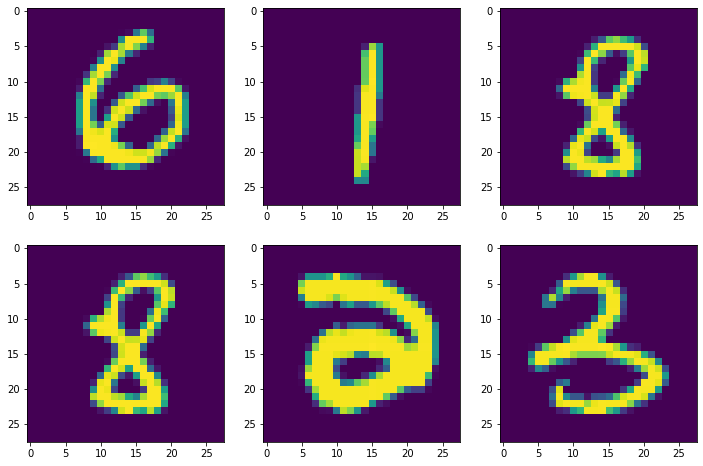

In [47]:
# plt.imshow(mnist.train.images[0].reshape(28,28))
# px.imshow(mnist.train.images[2].reshape(28,28))

nrow=2; ncol=3
fig, axes = plt.subplots(nrow,ncol,figsize=(4*ncol,4*nrow))
for i in range(nrow):
    for j in range(ncol):
        axes[i,j].imshow(mnist.train.images[ i*nrow+(j+1) ].reshape(28,28))

## DNN模型

这里构建一个 **输入层 + 隐藏层1 + 隐藏层2 + softmax层**，一共4层的神经网络，使用的内容如下：  
+ 每一层的激活函数使用ReLU函数
+ 损失函数使用L2正则项
+ 使用衰减的指数学习率

In [48]:
#------配置相关参数------
# 输入层节点数
INPUT_NODE = 784
# 输出层节点数——对应于10个分类
OUTPUT_NODE = 10
# 隐藏层1的节点数
LAYER_1_NODE = 500
# 隐藏层2的节点数
LAYER_2_NODE = 10

# batch大小
BATCH_SIZE = 100

# 训练轮次
TRAIN_STEPS = 3000

# 基础学习率和衰减率
LEARN_RATE = 0.08
DECAY_RATE = 0.9

# 正则化系数
LAMBDA = 0.01

In [49]:
def network_calculate(input_tensor, w1, b1, w2, b2):
    """
    计算网络前向传播得到的结果,不包括softmax层
    这里的网络是全连接层
    """
    # 隐藏层1的结果，使用了ReLU激活函数
    layer1 = tf.nn.relu(tf.matmul(input_tensor, w1) + b1)
    # 隐藏层2的结果，仍然使用ReLU
    layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)
    # softmax层
    # softmax = tf.nn.softmax(layer2)
    # 返回softmax层
    #return softmax
    # 这里不直接返回softmax层的结果，而是返回进行softmax之前的值
    return layer2


def network_predict(input_tensor, w1, b1, w2, b2):
    """
    用于计算网络前向传播得到的结果,这个返回的是softmax层之后的结果
    """
    # 隐藏层1的结果，使用了ReLU激活函数
    layer1 = tf.nn.relu(tf.matmul(input_tensor, w1) + b1)
    # 隐藏层2的结果，仍然使用ReLU
    layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)
    # softmax层
    softmax = tf.nn.softmax(layer2)
    # 返回softmax层
    return softmax


def network_train(mnist):
    """
    用于训练网络的函数
    """
    x_batch = tf.placeholder(tf.float32, shape=[None, INPUT_NODE], name='x_batch')
    y_batch = tf.placeholder(tf.float32, shape=[None, OUTPUT_NODE], name='y_batch')
    
    # 定义正则化函数
    reg_l2 = tf.contrib.layers.l2_regularizer(LAMBDA)
    
    # 定义两个隐藏层的参数，并将这两个隐藏层的参数加入到losses集合里
    w1 = tf.get_variable(name='w1', dtype=tf.float32, 
                        initializer=tf.random_normal([INPUT_NODE, LAYER_1_NODE]),
                        regularizer=reg_l2)
    w2 = tf.get_variable(name='w2', dtype=tf.float32, 
                        initializer=tf.random_normal([LAYER_1_NODE, LAYER_2_NODE]),
                        regularizer=reg_l2)
    # 注意，一般不对偏置项做正则化，所以不用将它们加入到对应的loss集合里
    b1 = tf.get_variable(name='b1', dtype=tf.float32,
                        initializer=tf.constant(0.1, shape=[LAYER_1_NODE]))
    b2 = tf.get_variable(name='b2', dtype=tf.float32,
                        initializer=tf.constant(0.1, shape=[LAYER_2_NODE]))
    
    # 定义网络前向传播结果的计算，注意，这里得到的结果不包括softmax层
    y_pred = network_calculate(x_batch,w1,b1,w2,b2)
    
    # 定义交叉熵损失函数的计算，这里使用TF自带的损失函数，它在计算的时候会包括softmax这一步
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_batch, logits=y_pred)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
    # 计算L2正则化损失
    # loss = cross_entropy_mean + reg_l2(w1) + reg_l2(w2)
    # 提取出经过正则化的变量集合
    reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    # 总的损失函数
    loss = cross_entropy_mean + tf.add_n(reg_variables)
    
    # 定义指数衰减的学习率
    # 定义全局的步数，这个变量不需要训练，不加入train集合, 所以trainable=False
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate=LEARN_RATE, global_step=global_step,
                                               decay_steps=mnist.train.num_examples/BATCH_SIZE,
                                               decay_rate=DECAY_RATE)
    
    # 定义梯度学习的优化器
    train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
                   .minimize(loss, global_step=global_step)
    
    # 初始化会话并开始训练
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        # 初始化所有变量
        sess.run(tf.global_variables_initializer())
        # 准备验证集
        feed_valid = {x_batch:mnist.validation.images, y_batch:mnist.validation.labels}
        # 迭代训练
        for step in range(TRAIN_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_step, feed_dict={x_batch:xs, y_batch:ys})
            # 每 200 轮输出一次在验证集上的loss
            if (step+1) % 200 == 0:
                valid_loss = sess.run(loss, feed_dict=feed_valid)
                print("经过 {} 轮训练后的在验证集上的交叉熵误差为：{:g}".format(step+1, valid_loss))
                
        # 由于整个计算图的数据只有在运行的Session中才能获得，所以需要在Session关闭前保存最终得到的两层神经网络的权重值并返回
        weights_1, weights_2, bias_1, bias_2 = sess.run((w1,w2,b1,b2))
    
    # 不能返回 w1,w2,b1,b2，它们只是variable,其中存储的最终的张量值只在上面的Session中存在，上面的Session一旦关闭，其中存储的张量值就消失了。
    # return w1,w2,b1,b2
    return weights_1,weights_2,bias_1,bias_2

In [50]:
%%time
# 这里需要限定变量的scope
# 首先重置整个计算图——主要是为了清除scope里的变量
tf.reset_default_graph()
# 输出当前计算图中的全局变量
# print("训练前的变量有：")
# display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
# print("----------------------------------------------")
# 创建一个scope，执行网络训练
with tf.variable_scope(name_or_scope='train', reuse=tf.AUTO_REUSE)  as train_scope:
#     network_train(mnist)
    (w1,w2,b1,b2) = network_train(mnist)
# 输出训练后的变量
# print("----------------------------------------------")
# print("训练之后的变量为：")
# display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

经过 200 轮训练后的在验证集上的交叉熵误差为：100.664
经过 400 轮训练后的在验证集上的交叉熵误差为：6.45011
经过 600 轮训练后的在验证集上的交叉熵误差为：1.95566
经过 800 轮训练后的在验证集上的交叉熵误差为：1.71977
经过 1000 轮训练后的在验证集上的交叉熵误差为：1.67968
经过 1200 轮训练后的在验证集上的交叉熵误差为：1.84289
经过 1400 轮训练后的在验证集上的交叉熵误差为：1.67013
经过 1600 轮训练后的在验证集上的交叉熵误差为：1.83942
经过 1800 轮训练后的在验证集上的交叉熵误差为：1

In [51]:
%%time
# 使用CPU进行计算
# 这里需要限定变量的scope
# 首先重置整个计算图——主要是为了清除scope里的变量
tf.reset_default_graph()
# 输出当前计算图中的全局变量
# print("训练前的变量有：")
# display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
# print("----------------------------------------------")
# 创建一个scope，执行网络训练
with tf.device('/cpu:0'):
    with tf.variable_scope(name_or_scope='train', reuse=tf.AUTO_REUSE)  as train_scope:
    #     network_train(mnist)
        (w1,w2,b1,b2) = network_train(mnist)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

经过 200 轮训练后的在验证集上的交叉熵误差为：100.219
经过 400 轮训练后的在验证集上的交叉熵误差为：7.01822
经过 600 轮训练后的在验证集上的交叉熵误差为：2.55724
经过 800 轮训练后的在验证集上的交叉熵误差为：2.31795
经过 1000 轮训练后的在验证集上的交叉熵误差为：2.30363
经过 1200 轮训练后的在验证集上的交叉熵误差为：2.30268
经过 1400 轮训练后的在验证集上的交叉熵误差为：2.30261
经过 1600 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 1800 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 2000 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 2200 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 2400 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 2600 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 2800 轮训练后的在验证集上的交叉熵误差为：2.3026
经过 3000 轮训练后的在验证集上的交叉熵误差为：2.3026
Wall time: 6.36 s


## DNN模型-重构版

重构版会将上面的文件拆成三部分：
1. `mnist_inference.py`，定义前向传播过程和神经网络中的参数——也就是网络的结构
2. `mnist_train.py`，定义了神经网络的训练过程
3. `mnist_eval.py`，定义了神经网络的预测或者测试过程

上述这种分离的方式，**可以灵活的更改网络结构，因为网络结构只是定义在`mnist_inference.py`中，后两个文件只是调用最外面的接口**。

In [37]:
xs, ys = mnist.train.next_batch(100)

In [40]:
xs.shape

(100, 784)

In [41]:
ys.shape

(100, 10)

In [ ]:
w = tf.constant([[1.0, 2.0, 3.0]
                 [4.0, 5.0, 6.0]])
x = tf.constant([1.0, 1.0])
res = tf.matmul()

----

## CNN：LeNet-5模型

原始的LeNet-5模型总共有7层（不包含输入层）
1. 输入层：32x32x1
2. 卷积层：6 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x1x6，输出尺寸为 32-5+1=28，即 28x28x6
3. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 14x14x6
4. 卷积层：16 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x6x16，输出尺寸为 14-5+1=10，即 10x10x16
5. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 5x5x6
6. 全连接层：输出节点个数为 120
7. 全连接层：输出节点个数为 84
8. 全连接层；输出节点个数为 10

在MNIST数据集上的应用就是：
1. 输入层：28x28x1
2. 卷积层：32 个过滤器，步长为 1，**使用0填充**，卷积核为 5x5x1x32，输出尺寸为 28x28x32
3. 池化层：窗口大小为 2x2，步长为 2，**使用0填充**，输出尺寸为 14x14x32
4. 卷积层：64 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x32x64，输出尺寸为 14-5+1=10，即 10x10x64
5. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 5x5x64
6. 全连接层：节点个数为 512
7. 全连接层：节点个数为 10

In [108]:
valid = mnist.validation.images

In [109]:
valid.shape

(5000, 784)

## 草稿  
下面这一段是草稿，用于练习正则化和variable scope的。

In [13]:
tf.get_variable_scope().reuse

False

In [201]:
# 这里使用variable_scope并设置reuse = tf.AUTO_REUSE是为了重复使用tf.get_variable()定义变量
with tf.variable_scope(name_or_scope='params', reuse=tf.AUTO_REUSE):
    x_batch = tf.placeholder(tf.float32, shape=[None, INPUT_NODE], name='x_batch')
    y_batch = tf.placeholder(tf.float32, shape=[None, OUTPUT_NODE], name='y_batch')

    # 定义正则化函数
    reg_l2 = tf.contrib.layers.l2_regularizer(tf.constant(LAMBDA))
    # 生成两个隐藏层的参数，并将这两个隐藏层的参数加入到losses集合里
    w1 = tf.get_variable(name='w1', dtype=tf.float32, 
                        initializer=tf.random_normal([INPUT_NODE, LAYER_1_NODE]),
                        regularizer=reg_l2)
    w2 = tf.get_variable(name='w2', dtype=tf.float32, 
                        initializer=tf.random_normal([LAYER_1_NODE, LAYER_2_NODE]),
                        regularizer=reg_l2)
    b1 = tf.get_variable(name='b1', dtype=tf.float32,
                        initializer=tf.constant(0.1, shape=[LAYER_1_NODE]))
    b2 = tf.get_variable(name='b2', dtype=tf.float32,
                        initializer=tf.constant(0.1, shape=[LAYER_2_NODE]))

In [171]:
# sess.run(tf.global_variables_initializer())
# w1.eval()

问题：
> 如何获取variable所属的集合？

In [202]:
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
print(reg_variables.__class__)
reg_variables

<class 'list'>


[]

In [197]:
# 清除某个collection里的内容
graph = tf.get_default_graph()
graph.clear_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

In [198]:
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_variables

[]

# RNN练习

## RNN拟合$sin$函数序列
这里展示一个使用RNN拟合$sin$函数的例子

In [72]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px
from IPython.display import display
%matplotlib inline

In [73]:
TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_INTERVAL = 0.01*np.pi
TIME_STEPS = 10

RNN输入数据的shape=(batch_size, time_steps, input_size)，特别要注意 time_steps 这个维度.
这里的输入数据 time_steps = 1
train_X.shape:  (10000, 1, 10)
train_y.shape:  (10000, 1)
test_X.shape:  (1000, 1, 10)
test_y.shape:  (1000, 1)


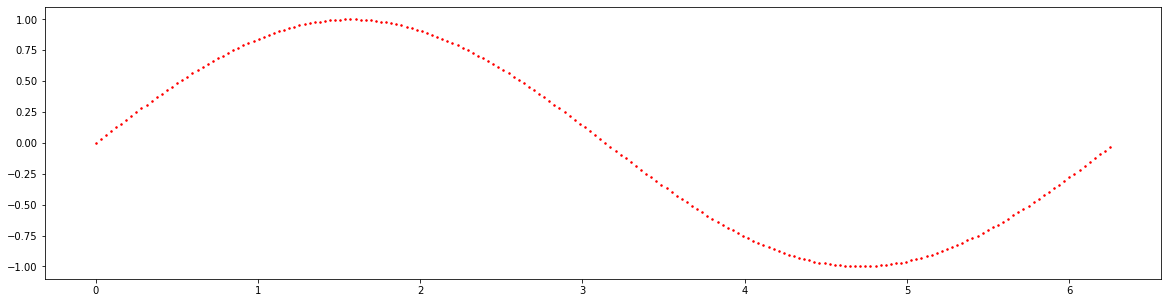

In [104]:
# 构造数据集
# 需要注意的是，RNN输入数据的shape=(batch_size, time_steps, input_size)，特别要注意 time_steps 这个维度.
def generate_data(seq):
    """
    从序列seq中进行采样，用 [第i项: TIME_STEPS-1项]作为输入值X， 第 i+TIMES_STEPS 项作为Y值
    """
    X = []
    Y = []
    # 序列的第i项和后面的TIME_STEPS-1项合在一起作为输入；第i + TIME_STEPS项作为输出。
    # 即用sin函数前面的TIME_STEPS个点的信息，预测第i + TIME_STEPS个点的函数值。
    for i in range(len(seq)-TIME_STEPS):
        X.append([seq[i: (i+TIME_STEPS)]])
        #X.append(seq[i: (i+TIME_STEPS)])
        Y.append([seq[i+TIME_STEPS]])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

# 训练数据集的取值区间是 [0, test_start]，这中间取 TRAINING_EXAMPLES + TIME_STEPS 个点
test_start = (TRAINING_EXAMPLES + TIME_STEPS) * SAMPLE_INTERVAL
# 测试数据集的取值区间是 [test_start, test_end]， 这中间取 TESTING_EXAMPLES + TIME_STEPS 个点
test_end = test_start + (TESTING_EXAMPLES + TIME_STEPS) * SAMPLE_INTERVAL

seq_train_x = np.linspace(0, test_start, TRAINING_EXAMPLES + TIME_STEPS, dtype=np.float32)
seq_train_y = np.sin(seq_train_x)
seq_test_x = np.linspace(test_start, test_end, TESTING_EXAMPLES + TIME_STEPS, dtype=np.float32)
seq_test_y = np.sin(seq_test_x)

# 注意，这里是要用sin值序列的 第i项: TIME_STEPS-1 项 预测 第 i+TIMES_STEPS 项，所以只需要 seq_train_y值，不需要横坐标的值
train_X, train_y = generate_data(seq_train_y)
test_X, test_y = generate_data(seq_test_y)

print("RNN输入数据的shape=(batch_size, time_steps, input_size)，特别要注意 time_steps 这个维度.")
print("这里的输入数据 time_steps = 1")
print("train_X.shape: ", train_X.shape)
print("train_y.shape: ", train_y.shape)
print("test_X.shape: ", test_X.shape)
print("test_y.shape: ", test_y.shape)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(seq_train_x[:200], seq_train_y[:200], "r.",markersize=3)

In [141]:
TRAINING_STEPS = 10000
BATCH_SIZE = 100

HIDDEN_SIZE = 30
NUM_LAYERS = 2
LEARNING_RATE = 0.01
DECAY_RATE = 0.9

# 定义多层的LSTM模型
def lstm_model(X, y, is_training):
    layer1_cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    layer2_cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    multi_cells = tf.nn.rnn_cell.MultiRNNCell([layer1_cell, layer2_cell])
    
    # 使用动态RNN
    outputs, states = tf.nn.dynamic_rnn(cell=multi_cells, inputs=X, dtype=tf.float32)
    print("outputs.shape: ",outputs.shape, " ---> outputs的shape=(batch_size, time_steps, input_size).")
    print("states[0].c ",states[0].c)
    print("states[0].h ",states[0].h)
    print("states[1].c: ",states[1].c)
    print("states[1].h: ",states[1].h)
    # 这里只关心最后一个time_step的输出结果，所以time_step维度切片为 -1. 
    # 其实这里的输入数据time_step就只有1维，这里做这个切片操作，是为了去掉time_step这个维度.
    output_final = outputs[:, -1, :]
    # 可以看出最后得到的output_final就没有了中间的time_step维度
    print("output_final.shape", output_final.shape)
    
    # 在LSTM之后，再加一层全连接层
    # 输入的个数为上面得到的 output_final 的节点个数，但是输出只有 1 个节点，也就是最终的数值
    output_pred = tf.contrib.layers.fully_connected(inputs=output_final, num_outputs=1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤，预测时直接返回结果
    if not is_training:
        return output_pred, None, None
    
    # 计算损失函数
    loss = tf.losses.mean_squared_error(labels=y, predictions=output_pred)

    # 定义全局的步数，这个变量不需要训练，不加入train集合, 所以trainable=False
    global_step = tf.Variable(0, trainable=False)
    # 定义指数衰减的学习率
    learning_rate = tf.train.exponential_decay(learning_rate=LEARNING_RATE, global_step=global_step,
                                               decay_steps=TRAINING_EXAMPLES/BATCH_SIZE,
                                               decay_rate=DECAY_RATE)
    
    # 定义梯度学习的优化器
    train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
                   .minimize(loss, global_step=global_step)
    
    return output_pred, loss, train_step


def lstm_train(sess, train_X, train_y):
    """
    训练函数
    """
    # 将训练数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    print("train_X:", X)
    print("train_y:", y)
    
    with tf.variable_scope("lstm-model"):
        predictions, loss, train_step = lstm_model(X, y, True)
    
    print("\ntf.GraphKeys.GLOBAL_VARIABLES: ")
    display(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        
    sess.run(tf.global_variables_initializer())
    print("\n训练过程如下：")
    for i in range(TRAINING_STEPS):
        _, loss_val = sess.run([train_step, loss])
        if i%500 == 0:
            print("train step {}, loss is: {:g}".format(i, loss_val))
            
    return None


def lstm_test(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    print("test_X:", X)
    print("test_y:", y)
    # 获取测试结果的operation
    with tf.variable_scope("lstm-model", reuse=True):
        # 获取前向传播结果，由于不是训练过程，所以这里传入的y随便填写就行
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将获得的结果放入list中
    pred_list = []
    label_list = []
    for i in range(TESTING_EXAMPLES):
        y_pred, y_true = sess.run([prediction, y])
        pred_list.append(y_pred)
        label_list.append(y_true)
    # 转成np.array，计算RMSE
    y_pred = np.array(pred_list)
    y_true = np.array(label_list)
    rmse = np.sqrt((y_pred-y_true)**2).mean()
    print("\n测试集上的RMSE为：{}".format(rmse))
    
    return None

In [142]:
tf.reset_default_graph()
with tf.Session() as sess:
    lstm_train(sess, train_X, train_y)
    print("\n测试过程如下：")
    lstm_test(sess, test_X, test_y)

train_X: Tensor("IteratorGetNext:0", shape=(?, 1, 10), dtype=float32)
train_y: Tensor("IteratorGetNext:1", shape=(?, 1), dtype=float32)
outputs.shape:  (?, 1, 30)  ---> outputs的shape=(batch_size, time_steps, input_size).
states[0].c  Tensor("lstm-model/rnn/while/Exit_3:0", shape=(?, 30), dtype=float32)
states[0].h  Tensor("lstm-model/rnn/while/Exit_4:0", shape=(?, 30), dtype=float32)
states[1].c:  Tensor("lstm-model/rnn/while/Exit_5:0", shape=(?, 30), dtype=float32)
states[1].h:  Tensor("lstm-model/rnn/while/Exit_6:0", shape=(?, 30), dtype=float32)
output_final.shape (?, 30)

tf.GraphKeys.GLOBAL_VARIABLES: 


[<tf.Variable 'lstm-model/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(40, 120) dtype=float32_ref>,
 <tf.Variable 'lstm-model/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'lstm-model/rnn/multi_rnn_cell/cell_1/basic_lstm_cell/kernel:0' shape=(60, 120) dtype=float32_ref>,
 <tf.Variable 'lstm-model/rnn/multi_rnn_cell/cell_1/basic_lstm_cell/bias:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'lstm-model/fully_connected/weights:0' shape=(30, 1) dtype=float32_ref>,
 <tf.Variable 'lstm-model/fully_connected/biases:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'lstm-model/Variable:0' shape=() dtype=int32_ref>]


训练过程如下：
train step 0, loss is: 0.515462
train step 500, loss is: 0.349856
train step 1000, loss is: 0.129152
train step 1500, loss is: 0.0623618
train step 2000, loss is: 0.0423575
train step 2500, loss is: 0.0350038
train step 3000, loss is: 0.0274251
train step 3500, loss is: 0.0279272
train step 4000, loss is: 0.02451
train step 4500, loss is: 0.0233054
train step 5000, loss is: 0.0254421
train step 5500, loss is: 0.0223711
train step 6000, loss is: 0.024345
train step 6500, loss is: 0.0225741
train step 7000, loss is: 0.021534
train step 7500, loss is: 0.0246775
train step 8000, loss is: 0.0261614
train step 8500, loss is: 0.0245077
train step 9000, loss is: 0.0228275
train step 9500, loss is: 0.0249539

测试过程如下：
test_X: Tensor("IteratorGetNext_1:0", shape=(?, 1, 10), dtype=float32)
test_y: Tensor("IteratorGetNext_1:1", shape=(?, 1), dtype=float32)
outputs.shape:  (?, 1, 30)  ---> outputs的shape=(batch_size, time_steps, input_size).
states[0].c  Tensor("lstm-model_1/rnn/while/Exit_3